In [17]:
%matplotlib inline


Group analysis of resting-state fMRI with ICA: CanICA
=====================================================

An example applying CanICA to resting-state data. This example applies it
to 30 subjects of the ADHD200 datasets. Then it plots a map with all the
components together and an axial cut for each of the components separately.

CanICA is an ICA method for group-level analysis of fMRI data. Compared
to other strategies, it brings a well-controlled group model, as well as a
thresholding algorithm controlling for specificity and sensitivity with
an explicit model of the signal. The reference papers are:

    * G. Varoquaux et al. "A group model for stable multi-subject ICA on
      fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299

    * G. Varoquaux et al. "ICA-based sparse features recovery from fMRI
      datasets", IEEE ISBI 2010, p. 1177

Pre-prints for both papers are available on hal
(http://hal.archives-ouvertes.fr)

<div class="alert alert-info"><h4>Note</h4><p>The use of the attribute `components_img_` from decomposition
    estimators is implemented from version 0.4.1.
    For older versions, unmask the deprecated attribute `components_`
    to get the components image using attribute `masker_` embedded in
    estimator.
    See the `section Inverse transform: unmasking data <unmasking_step>`.</p></div>



First we load the ADHD200 data
-------------------------------



In [18]:
import numpy as np
X=np.load('/storage/ADHD200/athena/NYU/All_Data.npy')

In [19]:
mask_img ='/storage/ADHD200/athena/NYU/ADHD200_mask_152_4mm.nii.gz'

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     detrend=1,
                     smoothing_fwhm=6.,
                     memory="/storage/nilearn_cache", 
                     memory_level=2)
masker.fit()


NiftiMasker(detrend=1, dtype=None, high_pass=None, low_pass=None,
      mask_args=None,
      mask_img='/storage/ADHD200/athena/NYU/ADHD200_mask_152_4mm.nii.gz',
      mask_strategy='background',
      memory=Memory(location=/storage/nilearn_cache/joblib),
      memory_level=2, sample_mask=None, sessions=None, smoothing_fwhm=6.0,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

Here we apply DL on the data
---------------------------------



In [20]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 1
original_dim=X.shape[1]
latent_dim = 40
intermediate_dim = 500
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(256, activation='tanh')(x)
h = Dense(128, activation='tanh')(h)
h = Dense(64, activation='tanh')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later

h_decoded = Dense(64, activation='tanh')(z)
h_decoded = Dense(128, activation='tanh')(h_decoded)
h_decoded = Dense(256, activation='tanh')(h_decoded)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x,x_decoded_mean )
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
from keras import optimizers
rmsprop=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.001)
vae.compile(optimizer=rmsprop)
vae.summary()


vae.fit(X,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

encoder = Model(x, z_mean)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28546)        0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 256)          7308032     input_3[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 128)          32896       dense_19[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 64)           8256        dense_20[0][0]                   
__________________________________________________________________________________________________
dense_22 (

In [22]:
decoder=Model(x, z)
y=decoder.predict(X,
        batch_size=batch_size)


In [42]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.01)
clf.fit(y,X)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
import numpy as np


def thresholding(components):
    S = np.sqrt(np.sum(components ** 2, axis=1))
    S[S == 0] = 1
    components /= S[:, np.newaxis]

    # Flip signs in each composant so that positive part is l1 larger
    # than negative part. Empirically this yield more positive looking maps
    # than with setting the max to be positive.
    for component in components:
        if np.sum(component > 0) < np.sum(component < 0):
            component *= -1
    return components
def plot_net(components):
    
    components_img=masker.inverse_transform(components) 
    
    from nilearn.plotting import plot_prob_atlas

    # Plot all ICA components together
    plot_prob_atlas(components_img, title='All ICA components')
    
    from nilearn.image import iter_img
    from nilearn.plotting import plot_stat_map, show

    for i, cur_img in enumerate(iter_img(components_img)):
        plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                      cut_coords=1, colorbar=False)

    show()

In [44]:
components=thresholding(clf.coef_.T  )


/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, 

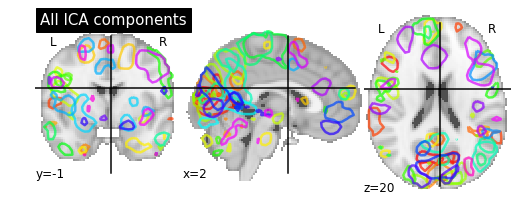

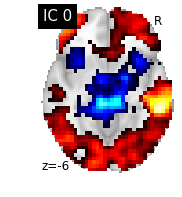

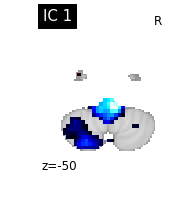

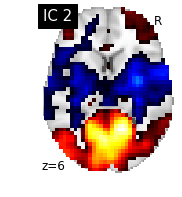

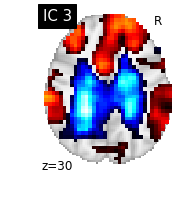

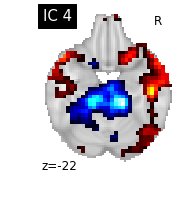

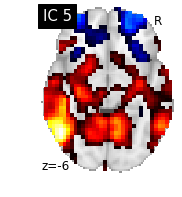

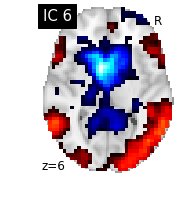

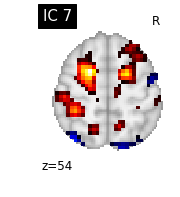

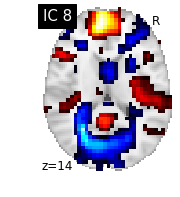

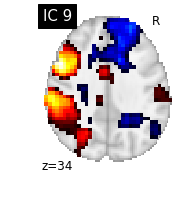

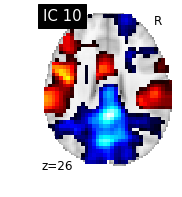

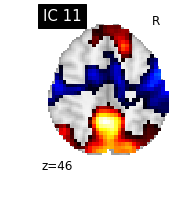

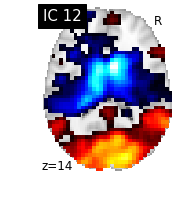

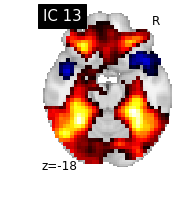

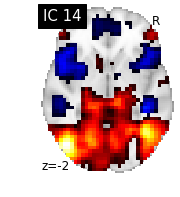

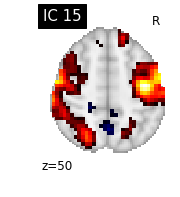

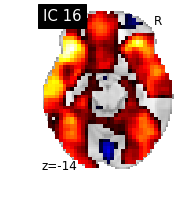

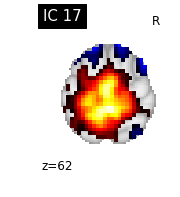

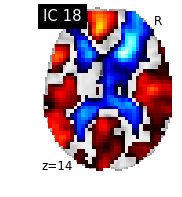

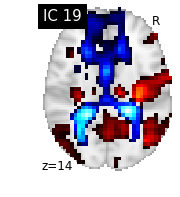

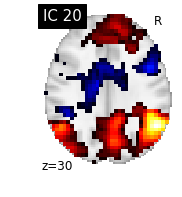

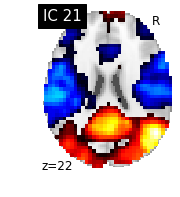

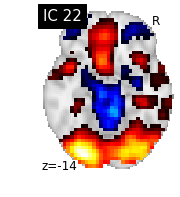

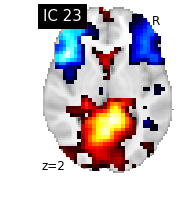

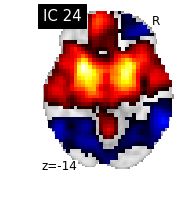

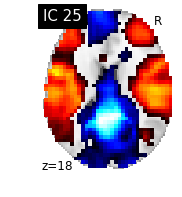

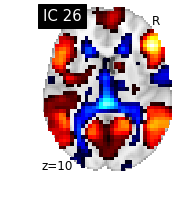

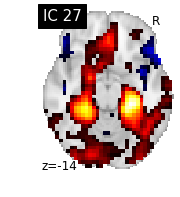

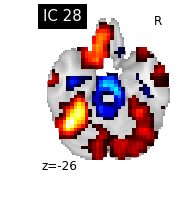

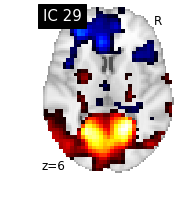

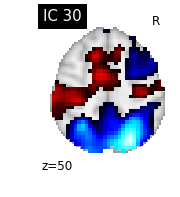

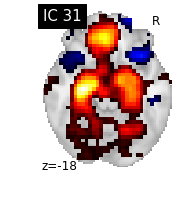

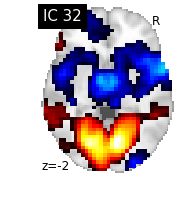

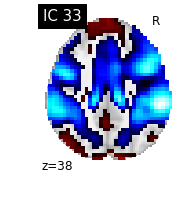

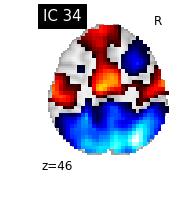

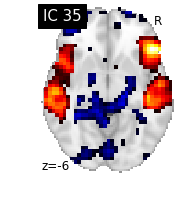

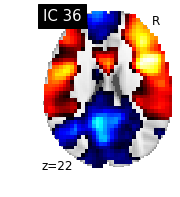

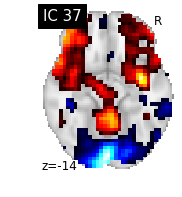

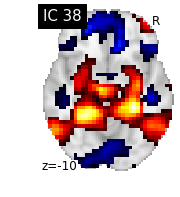

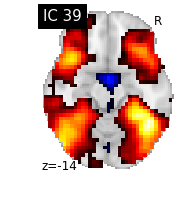

In [45]:
plot_net(components  )

In [33]:
np.save('/home/uga_qinglin/Documents/ADHD_DL/ADHD200_VAE_components.npy',components)
np.save('/home/uga_qinglin/Documents/ADHD_DL/ADHD200_VAE_diction.npy',y.T)

In [37]:
components.shape

(40, 28546)